In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
plt.rcParams.update({'font.size': 12})
IMAGES_FOLDER_PATH = os.path.join(os.path.dirname(os.path.abspath("main.ipynb")), 'tex/images')

In [2]:
from matplotlib import style
style.use('seaborn-v0_8-whitegrid')

In [3]:
def disturbance_delta(t, theta):
    return (1 + t)**(-1/8) * (1 - theta * (1 + t)**(-1/4) - 3/8 * (1 + t)**(-5/4))

def epsilon(x, xm):
    return x - xm


## Task 1

In [4]:
lambda_ = 4
theta_true = 1.0
gamma = 0.25
y0 = [1, 1, 1] 
t = np.linspace(0, 1000, 10000)  

In [5]:
def u(t, x, theta_hat, lambda_):
    return -theta_hat * x - lambda_ * x  

def adaptive_control_task_1(state, t, default_theta, lambda_, gamma):
    x, xm, theta_hat = state
    delta = disturbance_delta(t, default_theta)
    eps = epsilon(x, xm)
    
    dx = default_theta * x + u(t, x, theta_hat, lambda_) + delta
    
    dxm = -lambda_ * xm  
    
    dtheta_hat = -gamma * x * eps
    
    return [dx, dxm, dtheta_hat]

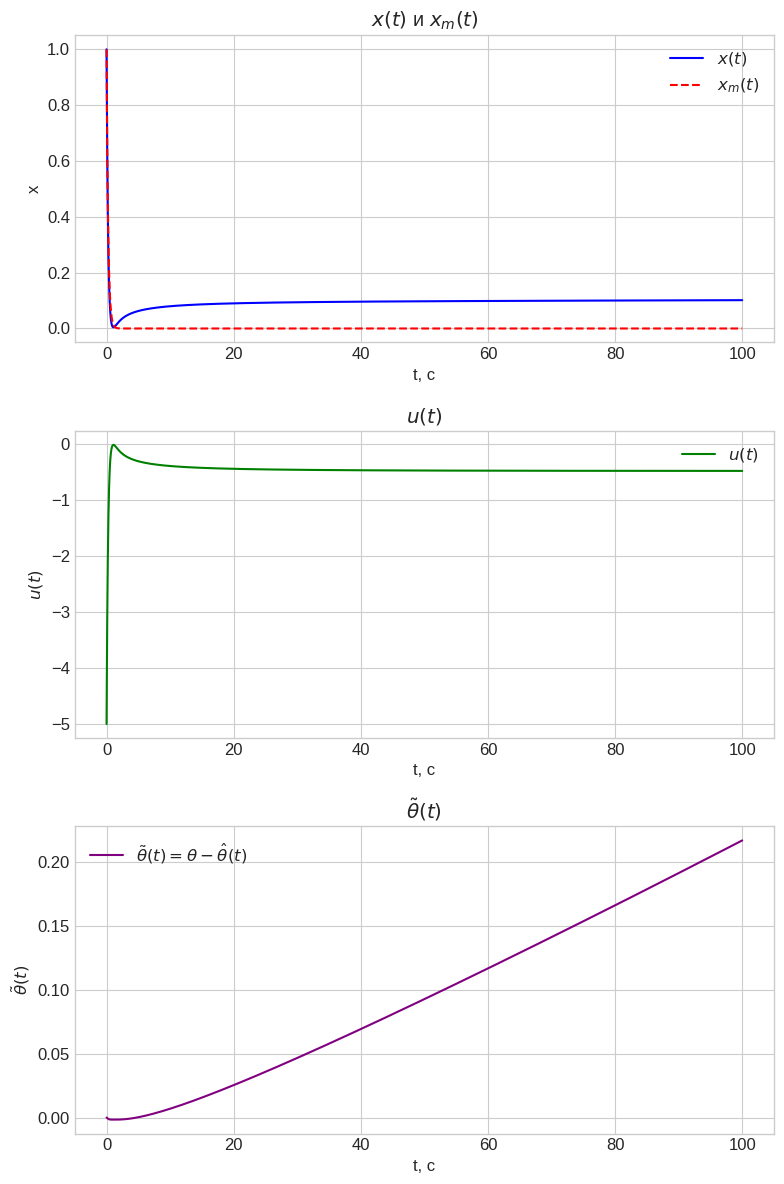

In [6]:
lambda_ = 4
theta_true = 1.0
gamma = 0.25
y0 = [1, 1, 1]  
t = np.linspace(0, 100, 10000) 

result = odeint(adaptive_control_task_1, y0, t, args=(theta_true, lambda_, gamma))

fig, axs = plt.subplots(3, 1, figsize=(8, 12))
fig.subplots_adjust(hspace=0.5)

# Первый график: x(t) и x_m(t)
axs[0].plot(t, result[:, 0], label='$x(t)$', color='b')
axs[0].plot(t, result[:, 1], label='$x_m(t)$', color='r', linestyle='--')
axs[0].set_title('$x(t)$ и $x_m(t)$')
axs[0].set_xlabel('t, с')
axs[0].set_ylabel('x')
axs[0].legend()
axs[0].grid(True)

# Второй 
u_vals = [u(ti, xi, result[j, 2], lambda_) for j, (ti, xi) in enumerate(zip(t, result[:, 0]))]
axs[1].plot(t, u_vals, label='$u(t)$', color='g')
axs[1].set_title('$u(t)$')
axs[1].set_xlabel('t, с')
axs[1].set_ylabel('$u(t)$')
axs[1].legend()
axs[1].grid(True)

# Третий 
theta_tilde = theta_true - result[:, 2]
axs[2].plot(t, theta_tilde, label='$\\tilde{\\theta}(t) = \\theta - \\hat{\\theta}(t)$', color='purple')
axs[2].set_title('$\\tilde{\\theta}(t)$')
axs[2].set_xlabel('t, с')
axs[2].set_ylabel('$\\tilde{\\theta}(t)$')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

## Task 2

In [7]:
# Управляющее воздействие с учётом γ и возмущения g(t)
def u(t, x, eps, gamma, lambda_, g):
    return gamma * x**2 * eps - lambda_ * x + lambda_ * g(t)

# Алгоритм статической обратной связи
def static_control(state, t, default_theta, g, gamma, lambda_):
    x, xm = state
    delta = disturbance_delta(t, default_theta)
    eps = epsilon(x, xm)
    
    # Управляющее воздействие
    dx = default_theta * x + u(t, x, eps, gamma, lambda_, g) + delta
    
    # Эталонная модель с учётом g(t)
    dxm = -lambda_ * (xm - g(t))
    
    return [dx, dxm]

In [8]:
# Задаем параметры моделирования
lambda_ = 100
theta_true = 1.5
y0 = [2.0, 1]  # x(0) = 1, x_m(0) = 1
t = np.linspace(0, 30, 10000)  # Время моделирования 1000 секунд

# Функция задания g(t)
g = lambda t: 3 * np.sin(t)  # Отличный от нуля сигнал задания

# Значения коэффициента γ для эксперимента
gamma_values = [0.001, 0.1, 5]

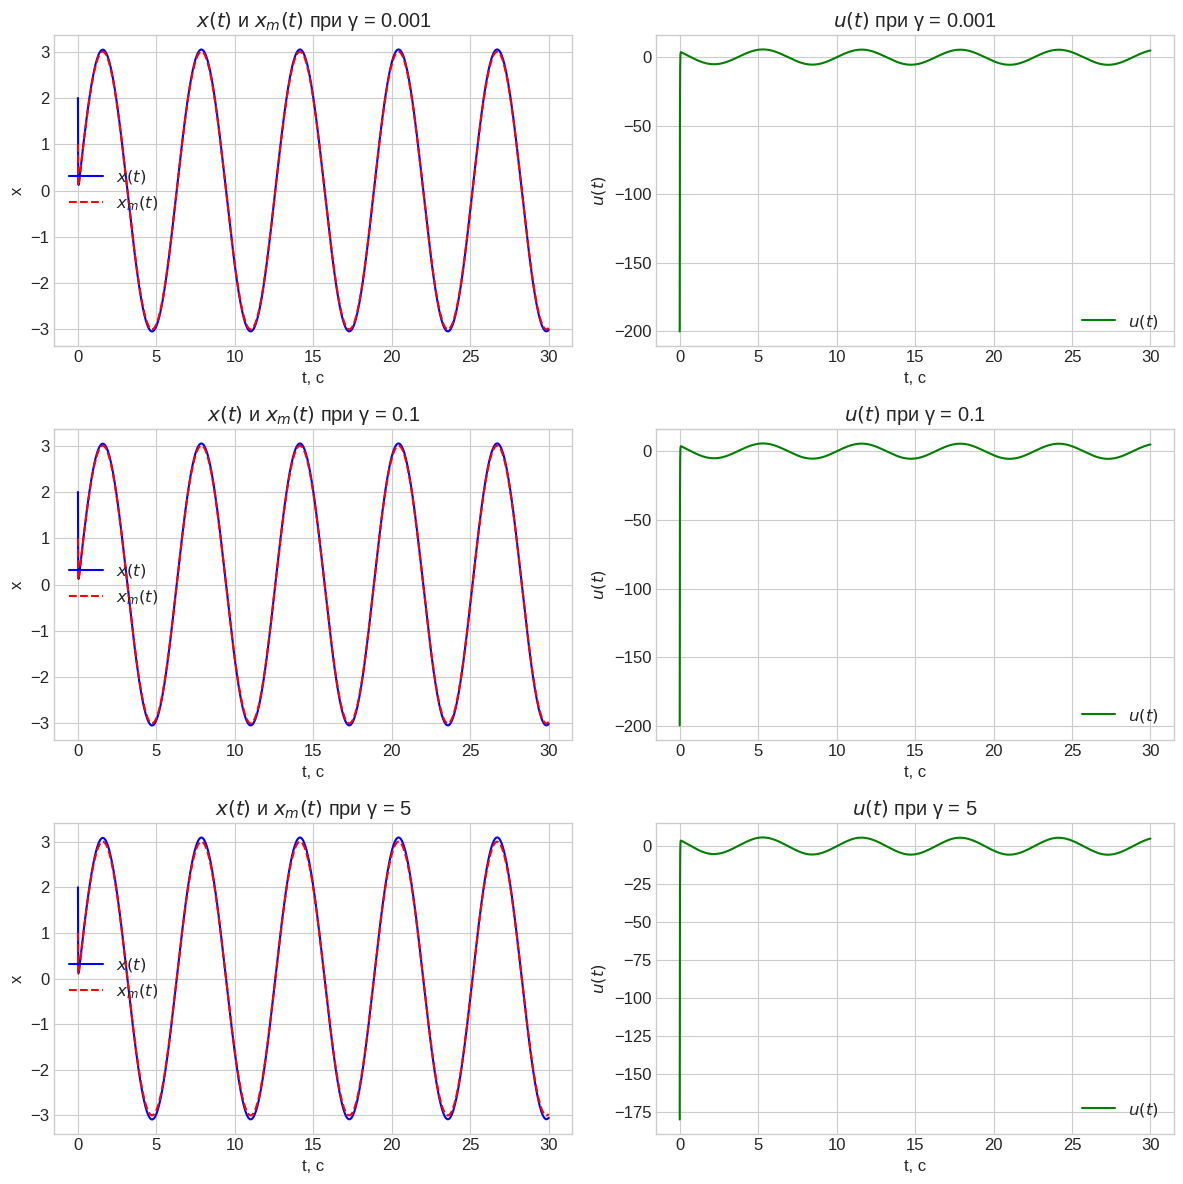

In [9]:
# Построение графиков для разных значений γ
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)

for i, gamma in enumerate(gamma_values):
    # Решаем уравнения для статической обратной связи
    result = odeint(static_control, y0, t, args=(theta_true, g, gamma, lambda_))

    # Первый график: x(t) и x_m(t)
    axs[i, 0].plot(t, result[:, 0], label='$x(t)$', color='b')
    axs[i, 0].plot(t, result[:, 1], label='$x_m(t)$', color='r', linestyle='--')
    axs[i, 0].set_title(f'$x(t)$ и $x_m(t)$ при γ = {gamma}')
    axs[i, 0].set_xlabel('t, с')
    axs[i, 0].set_ylabel('x')
    axs[i, 0].legend()
    axs[i, 0].grid(True)

    # Второй график: u(t)
    u_vals = [u(ti, xi, epsilon(xi, xmi), gamma, lambda_, g) for ti, xi, xmi in zip(t, result[:, 0], result[:, 1])]
    axs[i, 1].plot(t, u_vals, label='$u(t)$', color='g')
    axs[i, 1].set_title(f'$u(t)$ при γ = {gamma}')
    axs[i, 1].set_xlabel('t, с')
    axs[i, 1].set_ylabel('$u(t)$')
    axs[i, 1].legend()
    axs[i, 1].grid(True)

plt.tight_layout()
plt.show()

## Task 3

In [10]:
# Управляющее воздействие для робастной σ-модификации
def u(t, x, theta_hat, lambda_, g):
    return -theta_hat * x - lambda_ * x + lambda_ * g(t)

# Адаптивное управление с робастной σ-модификацией
def robust_control(state, t, default_theta, g, gamma, sigma, lambda_):
    x, xm, theta_hat = state
    delta = disturbance_delta(t, default_theta)
    eps = epsilon(x, xm)
    
    # Управляющее воздействие
    dx = default_theta * x + u(t, x, theta_hat, lambda_, g) + delta
    
    # Эталонная модель
    dxm = -lambda_ * (xm - g(t))
    
    # Адаптация параметра \hat{\theta} с учётом σ-модификации
    dtheta_hat = -sigma * theta_hat - gamma * x * eps
    
    return [dx, dxm, dtheta_hat]

In [13]:
# Задаем параметры моделирования
lambda_ = 4
theta_true = 1.0
y0 = [2, 1, 0]  # Начальные условия: x(0), x_m(0), \hat{\theta}(0)
t = np.linspace(0, 100, 10000)  # Время моделирования

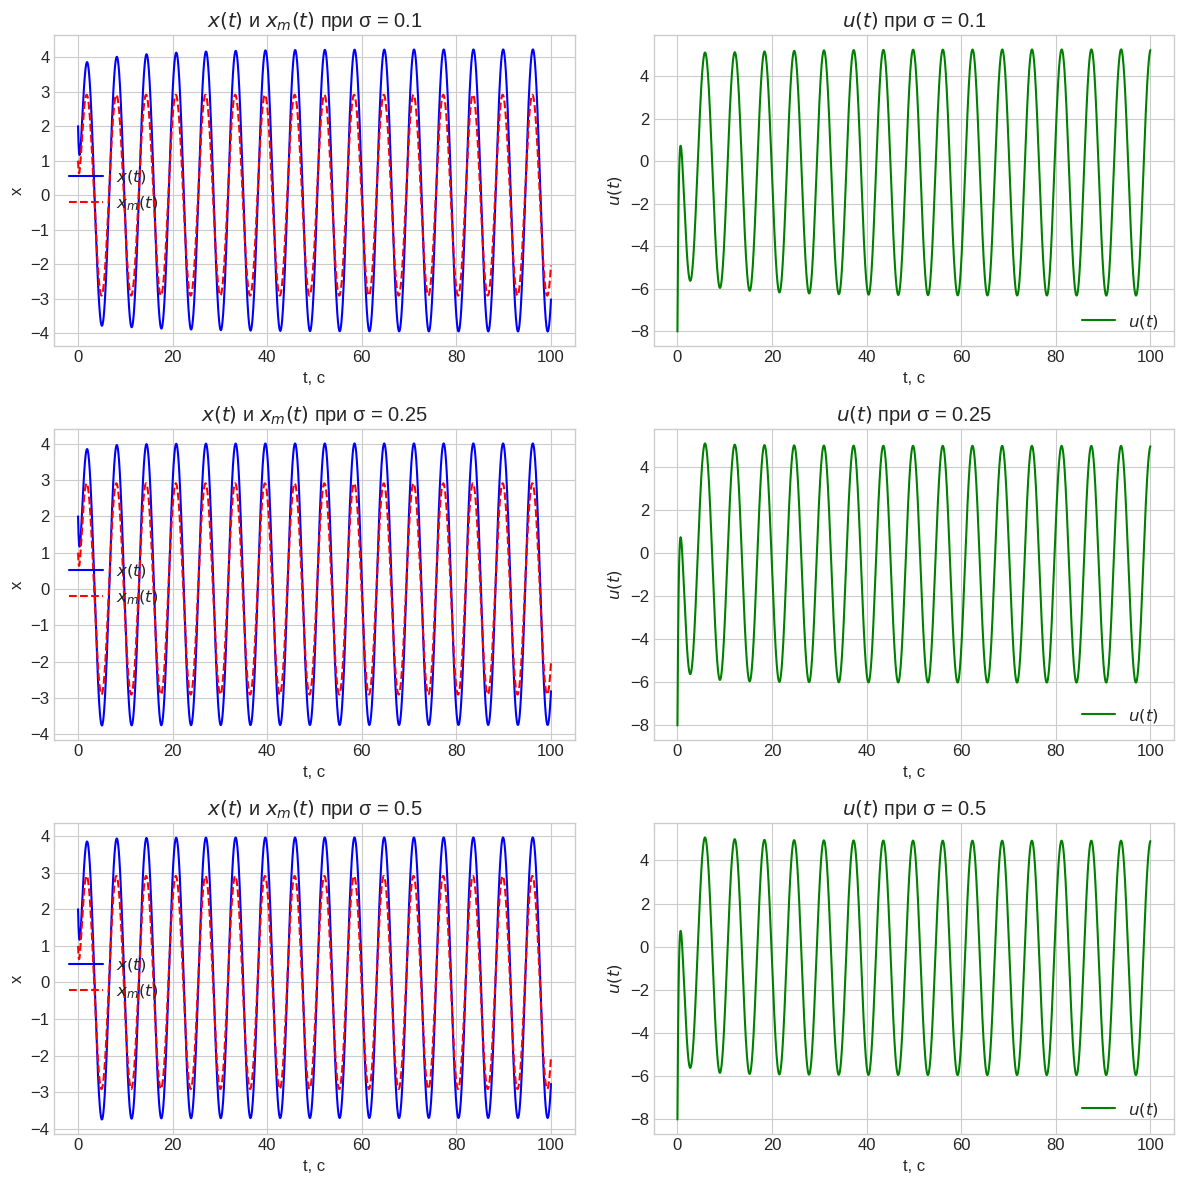

In [14]:

# Значения коэффициента σ для эксперимента
sigma_values = [0.1, 0.25, 0.5]
gamma = 0.01  # Фиксируем γ для робастной адаптации

# Построение графиков для разных значений σ
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)

for i, sigma in enumerate(sigma_values):
    # Решаем уравнения для робастной σ-модификации
    result = odeint(robust_control, y0, t, args=(theta_true, g, gamma, sigma, lambda_))

    # Первый график: x(t) и x_m(t)
    axs[i, 0].plot(t, result[:, 0], label='$x(t)$', color='b')
    axs[i, 0].plot(t, result[:, 1], label='$x_m(t)$', color='r', linestyle='--')
    axs[i, 0].set_title(f'$x(t)$ и $x_m(t)$ при σ = {sigma}')
    axs[i, 0].set_xlabel('t, с')
    axs[i, 0].set_ylabel('x')
    axs[i, 0].legend()
    axs[i, 0].grid(True)

    # Второй график: u(t)
    u_vals = [u(ti, xi, result[j, 2], lambda_, g) for j, (ti, xi) in enumerate(zip(t, result[:, 0]))]
    axs[i, 1].plot(t, u_vals, label='$u(t)$', color='g')
    axs[i, 1].set_title(f'$u(t)$ при σ = {sigma}')
    axs[i, 1].set_xlabel('t, с')
    axs[i, 1].set_ylabel('$u(t)$')
    axs[i, 1].legend()
    axs[i, 1].grid(True)

plt.tight_layout()
plt.show()